In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
n_cores
cluster <- makeCluster(16) 
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster,
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("mdir.logrank")
  library('foreach')
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

[1] 128

# Experiments

## Single Stage ( Proportional Hazard Assumption)
#### According to Jung (2017) double arms 2 stages log rank test (page 642)   
####  $H_0 : \lambda_0 = \lambda_1 = 1.609$    
####  $H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   


------

## 1. One sided(greater) Log rank test VS Simple RMST
### 1.1 (Jung 2017 page5 example 1)
#### It is annouced that 2 sample one-sided log rank test with N = 51 per arm 
#### The power can reach 0.9 when α = 0.1. 
#### Simple RMST: Reject $H_0$ when $RMST_E - RMST_C> m_1$


The simulated alpha of one-sided log rank test is: 0.0999 
The simulated alpha of one-sided Simple RMST test is: 0.1055 
************* The empirical alpha is closed to nominated alpha 0.1 ************* 
The simulated power of one-sided log rank test is: 0.9098 
The simulated power of simple rmst test is: 0.9002

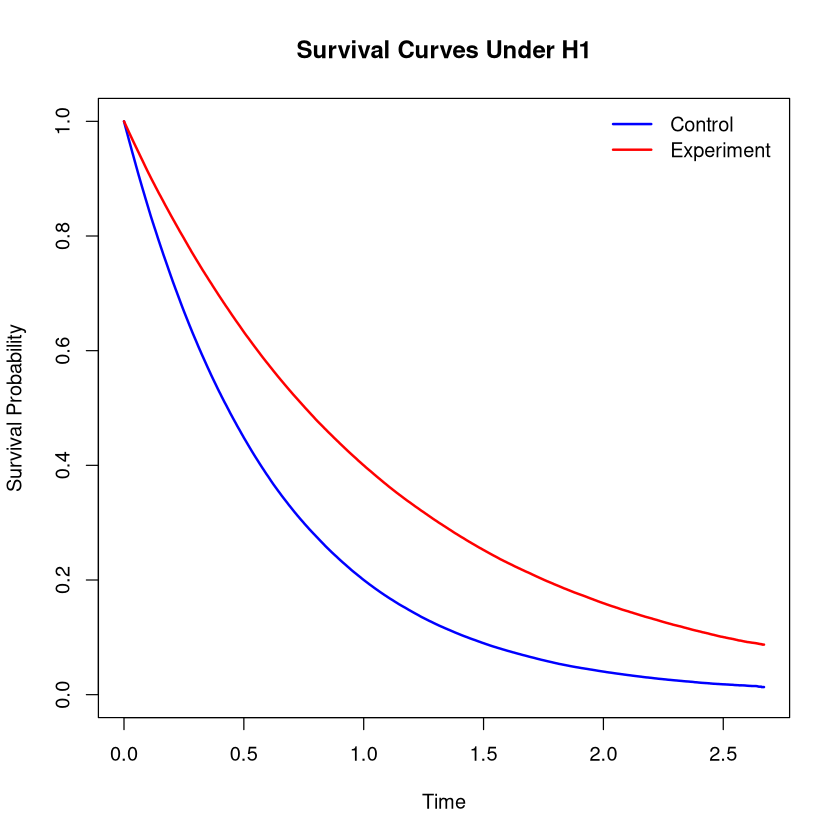

In [4]:
set.seed(2024)
sim_size = 10000
n = 51
acc_time <- 1.67
cen_time <- 1
tau <- 2

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
# survival curve
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
# Under H0
log_rank_a <- log_rank_sim(data_C = data_C, data_E = data_E_H0, sim_size = sim_size,
                            n = n,alpha = 0.1 ,sided = 'greater')
simple_rmst_a <- RMST_sim_test(data_C = data_C, data_E = data_E_H0, sim_size = sim_size, tau = tau,
                            n = n,alpha = 0.1 ,sided = 'greater')
cat('The simulated alpha of one-sided log rank test is:', log_rank_a$rejection, '\n')
cat('The simulated alpha of one-sided Simple RMST test is:',simple_rmst_a$test_result$rejection,'\n')
cat('************* The empirical alpha is closed to nominated alpha 0.1 *************','\n')
log_rank_b <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.1 ,sided = 'greater')
simple_rmst_b <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.1 ,sided = 'greater')
cat( 'The simulated power of one-sided log rank test is:', log_rank_b$rejection,'\n')
cat('The simulated power of simple rmst test is:', simple_rmst_b$test_result$rejection)

The logrank.test function should be reliable.

### 1.2 Eaton (2020) P288 Table1 (two-sided) Scenario 1

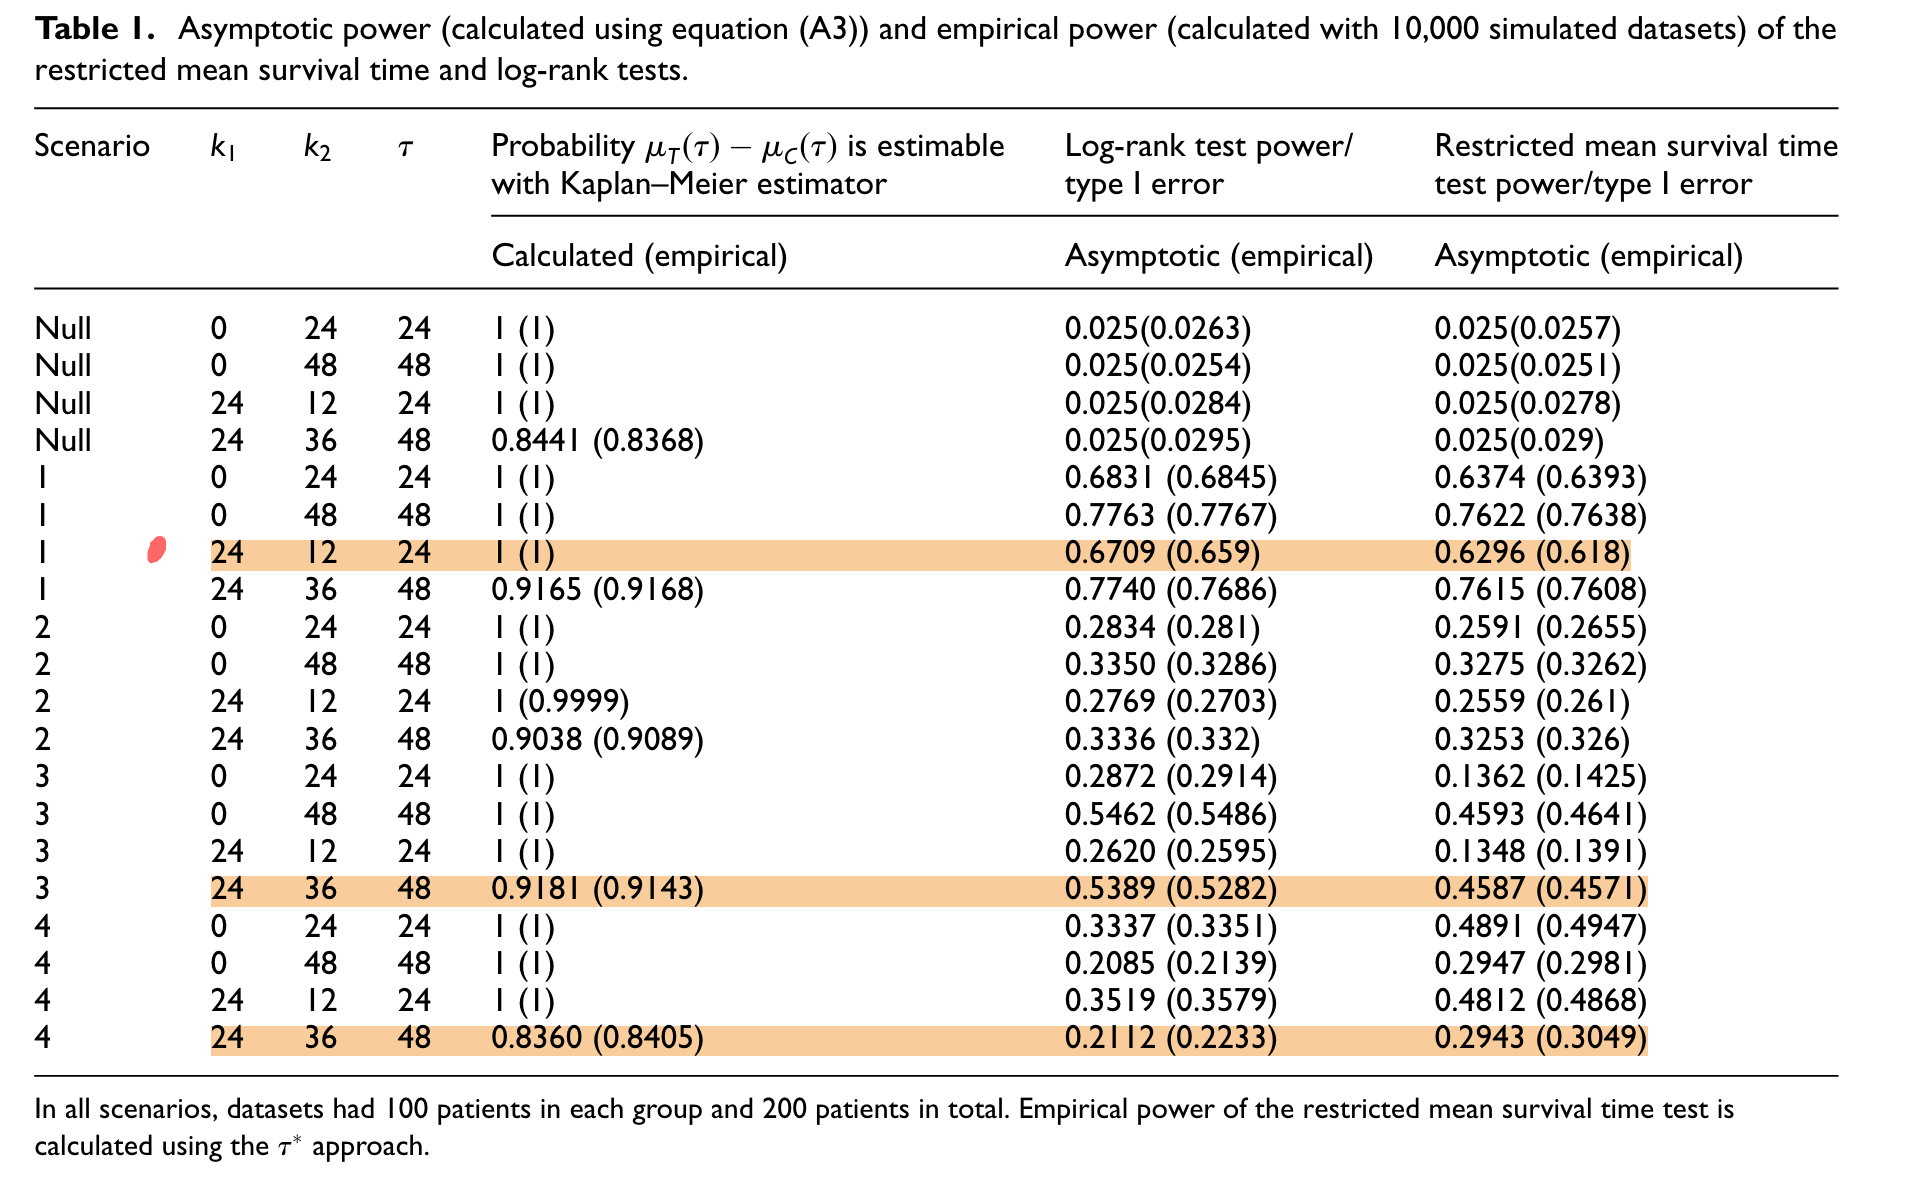

The simulated power of two-sided(alpha = 0.05) log rank test is: 0.6659 
The simulated power of two-sided(alpha = 0.05) simple rmst test is: 0.6229 
************* two sided test in Eaton 2020 *************  
The simulated power of one-sided(alpha = 0.05) log rank test is: 0.7735 
The simulated power of one-sided(alpha = 0.05) simple rmst test is: 0.7392

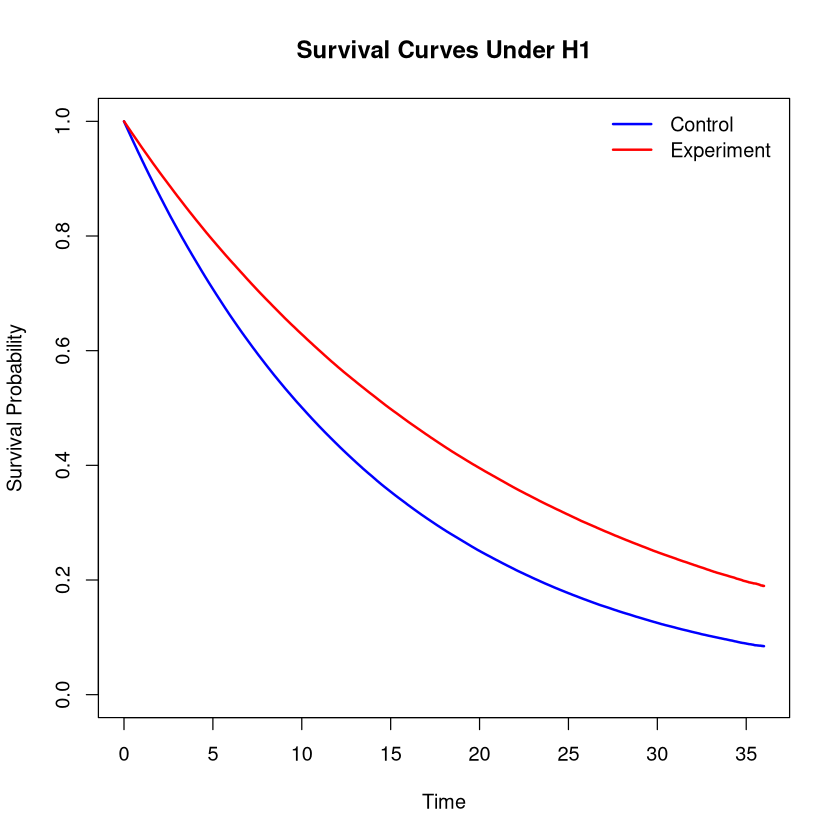

In [5]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
lambda_H1 <- lambda_H0 * 0.67
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 24
n <- 100  
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
    
# Under H1
log_rank_2 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
simple_rmst_2 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')                          
display_jpeg(file='figures/Eaton_2020_table1.JPEG')
cat( 'The simulated power of two-sided(alpha = 0.05) log rank test is:', log_rank_2$rejection,'\n')
cat('The simulated power of two-sided(alpha = 0.05) simple rmst test is:', simple_rmst_2$test_result$rejection,'\n')
cat('************* two sided test in Eaton 2020 ************* ','\n')
cat( 'The simulated power of one-sided(alpha = 0.05) log rank test is:', log_rank_1$rejection,'\n')
cat('The simulated power of one-sided(alpha = 0.05) simple rmst test is:', simple_rmst_1$test_result$rejection)

## Different hazard ratio. Compare power under $\alpha = 0.05$ 
#### Ust minimax $\tau$ for simple RMST. 
#### $H_0: \lambda_E = \lambda_C = \lambda_{H0}$
#### $H_1: \lambda_C = \lambda_{H0},\ \lambda_E = \lambda_{H1}$
#### Fix $\lambda_{H0}$, change $\lambda_{H1}$

In [7]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 36  # Set a large tau for minimax tau 
n <- 100  
interim <- acc_time
set.seed(2024)

diff_delta_single <- foreach(HR = seq(0.55, 1, by = 0.05), .combine = rbind) %dopar%
    {
        lambda_H1 <- lambda_H0 * HR
        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)  
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)
                            
        log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, n = n, alpha = 0.05 ,sided = 'greater')
        simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = tau, n = n, alpha = 0.05 ,sided = 'greater')

        # Monte Carlo for calculating critical value
        rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h0_int <- rmst_h0_fin                                 
        rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_int <- rmst_h1_fin 
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

        # Under H0
        mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
        # Under H1
        mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

        best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
        best_RMST <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Simple')

        c(HR, log_rank_1$rejection, simple_rmst_1$test_result$rejection, 
            best_RMST$power, best_our$power)      
    }

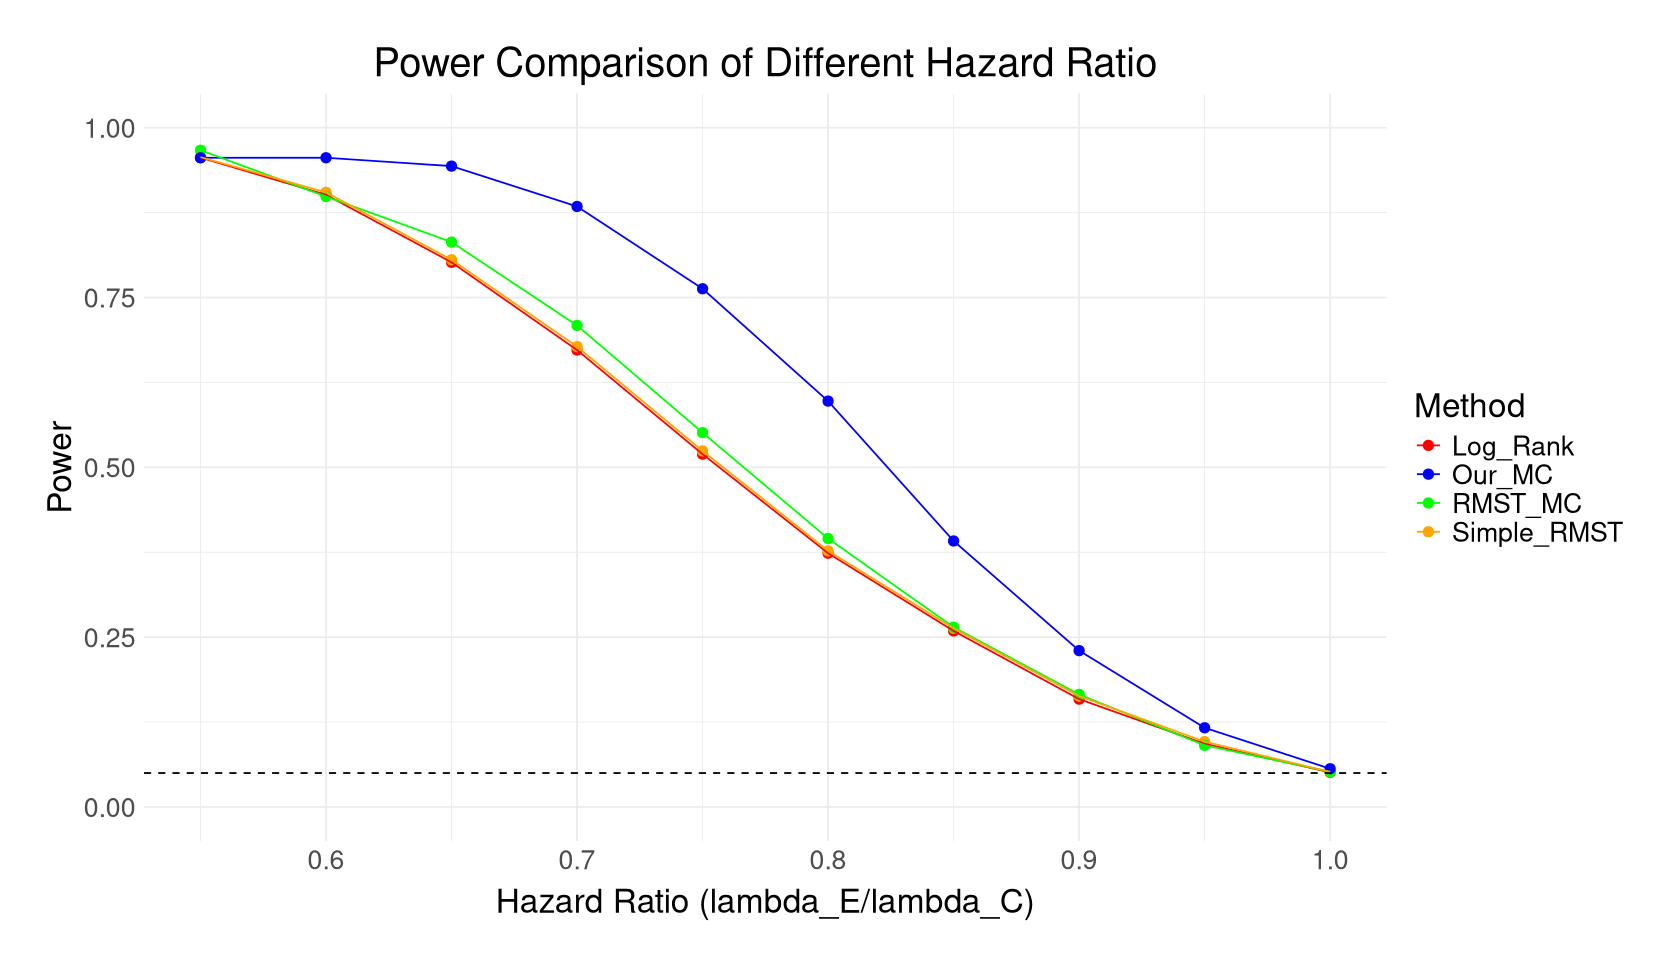

In [8]:
diff_delta_single <- data.frame(diff_delta_single)
colnames(diff_delta_single) <- c('HR','Log_Rank','Simple_RMST','RMST_MC', 'Our_MC')
diff_delta_single_long <- diff_delta_single %>% gather(key = "Method", value = "Power", -HR)
options(repr.plot.width = 14, repr.plot.height = 8)
custom_colors <- c("red", "blue", "green", "orange")
ggplot(diff_delta_single_long, aes(x = HR, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_y_continuous(limits = c(0, 1)) +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "black") +
  scale_color_manual(values = custom_colors) +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison of Different Hazard Ratio",
    x = "Hazard Ratio (lambda_E/lambda_C)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5),
        plot.margin = unit(c(1, 1, 1, 1), "cm"))


#### If we use minimax $\tau$ in RMST, the power would be almost the same as log rank
#### There is Monte Carlo error. RMST_MC would perform better but it's not true 
#### <span style="color:yellow">Our method is equivelent to grid search the critical value in single stage but the variance of this method is not guaranteed 
----
## Bootstrapping 95% Confidence Interval of the power
#### Here I used grid search to find the critical value for simple RMST and our RMST
#### simulation 5000 times and Bootstrap 500 times under each HR

In [10]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
sim_size <- 5000 
acc_time <- 24
cen_time <- 12
tau <- 36  # Set a large tau for minimax tau 
n <- 100  
interim <- acc_time
num_bootstrap <- 500 
set.seed(2024)
        
diff_hr_boot <- foreach(HR = seq(0.55, 0.85, by = 0.05), .combine = rbind) %dopar%
    {
        lambda_H1 <- lambda_H0 * HR
        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)  
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)
                            
        # Monte Carlo for calculating critical value
        rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                               
        rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        
        boot_sim_rmst <- c()
        boot_our_rmst <- c()
        for (i in 1:num_bootstrap) 
        {
            # Resample with replacement from H0 and H1
            bootstrap_H0 <- rmst_h0_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            bootstrap_H1 <- rmst_h1_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
  
            simple_rmst <- find_m_t_RMST(rmst_h0_fin = bootstrap_H0, rmst_h1_fin = bootstrap_H1, search_times = 100, 
                            alpha = 0.05, sim_size = sim_size, method = 'Simple')
            our_rmst <- find_m_t_RMST(rmst_h0_fin = bootstrap_H0, rmst_h1_fin = bootstrap_H1, search_times = 100, 
                            alpha = 0.05, sim_size = sim_size, method = 'Complex')
            boot_sim_rmst <- c(boot_sim_rmst, simple_rmst$power)
            boot_our_rmst <- c(boot_our_rmst, our_rmst$power)
        }

        c(HR, quantile(boot_sim_rmst, 0.025), mean(boot_sim_rmst), quantile(boot_sim_rmst, 0.975), 
            quantile(boot_our_rmst, 0.025), mean(boot_our_rmst), quantile(boot_our_rmst, 0.975))
    }

In [5]:
#save(diff_hr_boot, file = "RData/diff_hr_boot.RData")
load(file = "RData/diff_hr_boot.RData")

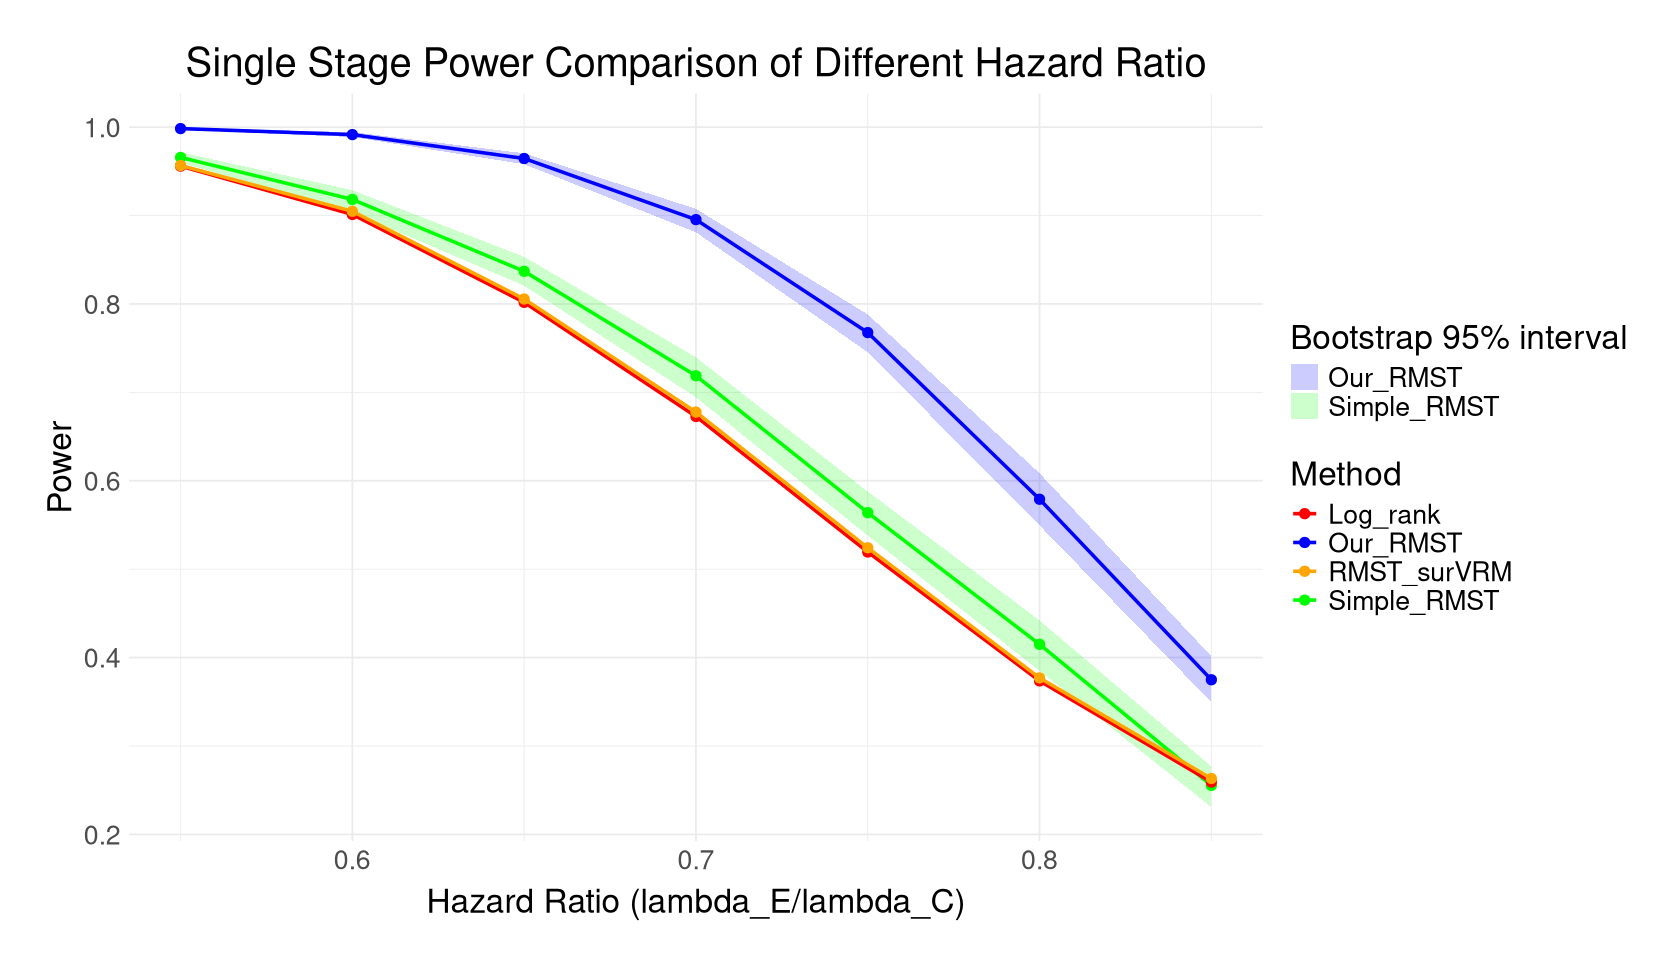

In [9]:
options(repr.plot.width = 14, repr.plot.height = 8)                      
ggplot() +
     geom_ribbon(data = diff_hr_boot, aes(x = HR, ymin = sim_rmst_0.025, 
                    ymax = sim_rmst_0.975,  fill = "Simple_RMST"), alpha = 0.2) +
     geom_line(data = diff_hr_boot, aes(x = HR, y = sim_rmst, color = "Simple_RMST"), linewidth = 1) +
     geom_point(data = diff_hr_boot, aes(x = HR, y = sim_rmst, color = "Simple_RMST"), size = 2.5) +

     geom_ribbon(data = diff_hr_boot, aes(x = HR, ymin = our_rmst_0.025, 
                    ymax = our_rmst_0.975, fill = "Our_RMST"), alpha = 0.2) +
     geom_line(data = diff_hr_boot, aes(x = HR, y = our_rmst, color = "Our_RMST"), linewidth = 1) +
     geom_point(data = diff_hr_boot, aes(x = HR, y = our_rmst, color = "Our_RMST"), size = 2.5) +
     
     geom_line(data = diff_delta_single[1:7,], aes(x = HR, y = Log_Rank, color = "Log_rank"), linewidth = 1) +
     geom_point(data = diff_delta_single[1:7,], aes(x = HR, y = Log_Rank, color = "Log_rank"), size = 2.5) +
     geom_line(data = diff_delta_single[1:7,], aes(x = HR, y = Simple_RMST, color = "RMST_surVRM"), linewidth = 1) +
     geom_point(data = diff_delta_single[1:7,], aes(x = HR, y = Simple_RMST, color = "RMST_surVRM"), size = 2.5) +
     
     theme_minimal() +
     labs(
          color = "Method",
          fill = "Bootstrap 95% interval",
          title = "Single Stage Power Comparison of Different Hazard Ratio",
          x = "Hazard Ratio (lambda_E/lambda_C)",
          y = "Power"
          ) +
     scale_fill_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue")) +
     scale_color_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue", 
                                   "Log_rank" = "red", "RMST_surVRM" = "orange")) +
     theme(text = element_text(size = 20),
          axis.title.x = element_text(vjust = 0),
          axis.title.y = element_text(vjust = 1),
          plot.title = element_text(hjust = 0.5),
          plot.margin = unit(c(1, 1, 1, 1), "cm"))

-------

## The Power and sample size N
#### When all other settings are fixed, the power should increase with increasing sample size N
#### The recruit rate is fixed. Larger sample size means longer accrual time.
#### In practise, this power can be calculate by Bootstrapping.

In [3]:
lambda_H0 <- 0.9
HR <- 0.67
lambda_H1 <- lambda_H0 * HR
sim_size <- 5000 
r <- 90 # recruit rate 5 patients per month
cen_time <- 1 
set.seed(2024)
num_bootstrap <- 500

diff_n_single <- foreach(n = seq(85, 115, by = 2), .combine = rbind) %dopar%
    {
        acc_time <- 2 * n / r
        interim <- acc_time
        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)  
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)
                            
        log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, n = n, alpha = 0.05 ,sided = 'greater')
        simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = acc_time + cen_time, n = n, alpha = 0.05 ,sided = 'greater')

        # Monte Carlo for calculating critical value
        rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h0_int <- rmst_h0_fin                                 
        rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_int <- rmst_h1_fin 
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

        # Under H0
        mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
        # Under H1
        mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)
        best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
        best_RMST <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Simple')
        m_sim <- as.numeric(best_RMST$m1)
        m_our <- as.numeric(best_our$m1)
        t_our <- as.numeric(best_our$t1)
        boot_sim_rmst <- c()
        boot_our_rmst <- c()
        for (i in 1:num_bootstrap) 
        {   # Resample with replacement from H0 and H1
            bootstrap_H0 <- rmst_h0_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            bootstrap_H1 <- rmst_h1_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            alpha_sim <- sum(bootstrap_H0[2, ] - bootstrap_H0[1, ] > m_sim) / sim_size
            power_sim <- sum(bootstrap_H1[2, ] - bootstrap_H1[1, ] > m_sim) / sim_size
            alpha_our <- sum(bootstrap_H0[2, ] - bootstrap_H0[1, ] > m_our &
                             bootstrap_H0[2, ] >  t_our) / sim_size
            power_our <- sum(bootstrap_H1[2, ] - bootstrap_H1[1, ] > m_our &
                             bootstrap_H1[2, ] >  t_our) / sim_size
            boot_sim_rmst <- cbind(boot_sim_rmst, c(alpha_sim, power_sim))
            boot_our_rmst <- cbind(boot_our_rmst, c(alpha_our, power_our))
        }
        sim_result <- c(quantile(boot_sim_rmst[2,], 0.025), mean(boot_sim_rmst[2,]), 
                        quantile(boot_sim_rmst[2,], 0.975))
        our_result <- c(quantile(boot_our_rmst[2,], 0.025), mean(boot_our_rmst[2,]), 
                        quantile(boot_our_rmst[2,], 0.975))
        c(n, log_rank_1$rejection, simple_rmst_1$test_result$rejection, 
            sim_result, our_result)      
    }

## Proportional Hazard

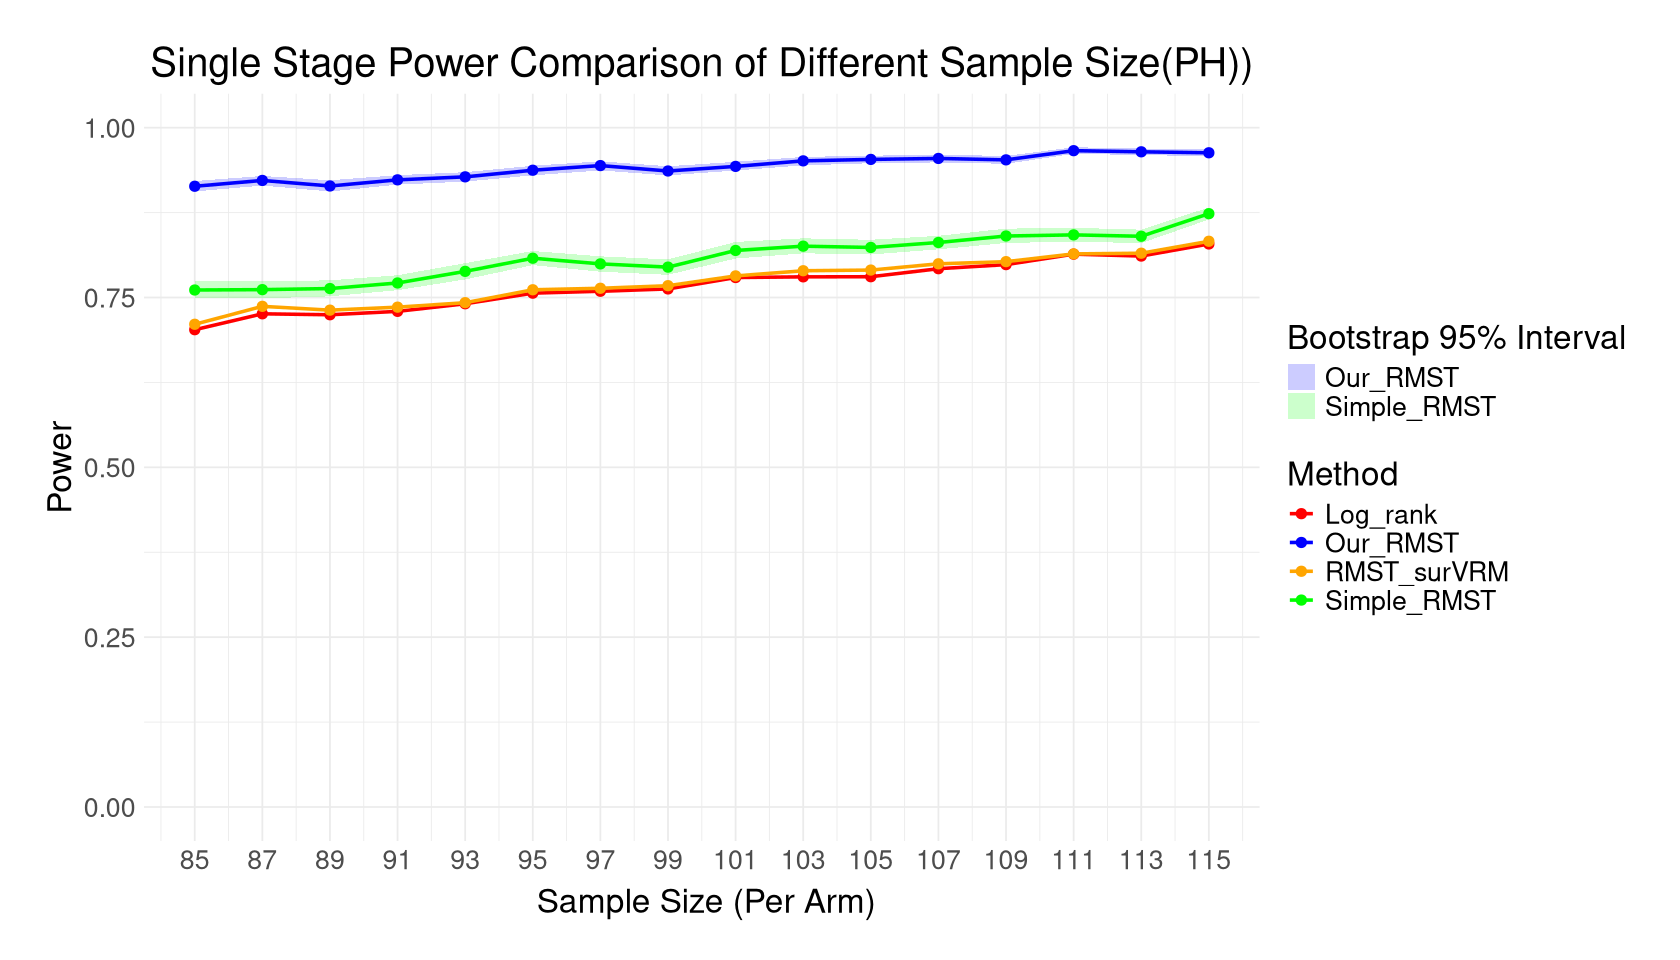

In [4]:
diff_n_single <- data.frame(diff_n_single)
colnames(diff_n_single) <- c('n','Log_Rank','RMST_surVRM','sim_rmst_0.025','Simple_RMST',
                         'sim_rmst_0.975', 'our_rmst_0.025', 'Our_RMST', 'our_rmst_0.975')

options(repr.plot.width = 14, repr.plot.height = 8)                      
ggplot() +
     geom_ribbon(data = diff_n_single, aes(x = n, ymin = sim_rmst_0.025, 
                    ymax = sim_rmst_0.975,  fill = "Simple_RMST"), alpha = 0.2) +
     geom_line(data = diff_n_single, aes(x = n, y = Simple_RMST, color = "Simple_RMST"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Simple_RMST, color = "Simple_RMST"), size = 2.5) +

     geom_ribbon(data = diff_n_single, aes(x = n, ymin = our_rmst_0.025, 
                    ymax = our_rmst_0.975, fill = "Our_RMST"), alpha = 0.2) +
     geom_line(data = diff_n_single, aes(x = n, y = Our_RMST, color = "Our_RMST"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Our_RMST, color = "Our_RMST"), size = 2.5) +

     geom_line(data = diff_n_single, aes(x = n, y = Log_Rank, color = "Log_rank"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Log_Rank, color = "Log_rank"), size = 2.5) +
     geom_line(data = diff_n_single, aes(x = n, y = RMST_surVRM, color = "RMST_surVRM"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = RMST_surVRM, color = "RMST_surVRM"), size = 2.5) +
     
     theme_minimal() +
     scale_x_continuous(breaks = diff_n_single$n) + 
     labs(
          color = "Method",
          fill = "Bootstrap 95% Interval",
          title = "Single Stage Power Comparison of Different Sample Size(PH))",
          x = " Sample Size (Per Arm)",
          y = "Power"
          ) +
     scale_fill_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue")) +
     scale_color_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue", 
                                   "Log_rank" = "red", "RMST_surVRM" = "orange")) +
     scale_y_continuous(limits = c(0, 1)) +
     theme(text = element_text(size = 20),
          axis.title.x = element_text(vjust = 0),
          axis.title.y = element_text(vjust = 1),
          plot.title = element_text(hjust = 0.5),
          plot.margin = unit(c(1, 1, 1, 1), "cm"))

-----


## Early Difference

In [20]:
lambda_H0 <- 0.9
HR1 <- 0.67
HR2 <- 1
sim_size <- 5000  
r <- 90    # patient recruit rate
cen_time <- 1
change_time <- 200 * 0.5 / 90 # The time point between HR1 and HR2
set.seed(2024)
num_bootstrap <- 500 

diff_n_single <- foreach(n = seq(85, 115, by = 2), .combine = rbind) %dopar%
    {
        acc_time <- 2 * n / r
        interim <- acc_time

        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)  
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
                            
        log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, n = n, alpha = 0.05 ,sided = 'greater')
        simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = acc_time + cen_time, n = n
                            ,alpha = 0.05 ,sided = 'greater')

        # Monte Carlo for calculating critical value
        rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h0_int <- rmst_h0_fin                                 
        rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_int <- rmst_h1_fin 
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

        # Under H0
        mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
        # Under H1
        mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

        best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
        best_RMST <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Simple')
        
        m_sim <- as.numeric(best_RMST$m1)
        m_our <- as.numeric(best_our$m1)
        t_our <- as.numeric(best_our$t1)
        boot_sim_rmst <- c()
        boot_our_rmst <- c()
        for (i in 1:num_bootstrap) 
        {
            # Resample with replacement from H0 and H1
            bootstrap_H0 <- rmst_h0_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            bootstrap_H1 <- rmst_h1_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            alpha_sim <- sum(bootstrap_H0[2, ] - bootstrap_H0[1, ] > m_sim) / sim_size
            power_sim <- sum(bootstrap_H1[2, ] - bootstrap_H1[1, ] > m_sim) / sim_size
            alpha_our <- sum(bootstrap_H0[2, ] - bootstrap_H0[1, ] > m_our &
                             bootstrap_H0[2, ] >  t_our) / sim_size
            power_our <- sum(bootstrap_H1[2, ] - bootstrap_H1[1, ] > m_our &
                             bootstrap_H1[2, ] >  t_our) / sim_size
            boot_sim_rmst <- cbind(boot_sim_rmst, c(alpha_sim, power_sim))
            boot_our_rmst <- cbind(boot_our_rmst, c(alpha_our, power_our))
        }
        sim_result <- c(quantile(boot_sim_rmst[2,], 0.025), mean(boot_sim_rmst[2,]), 
                        quantile(boot_sim_rmst[2,], 0.975))
        our_result <- c(quantile(boot_our_rmst[2,], 0.025), mean(boot_our_rmst[2,]), 
                        quantile(boot_our_rmst[2,], 0.975))

        c(n, log_rank_1$rejection, simple_rmst_1$test_result$rejection, 
            sim_result, our_result)      
    }

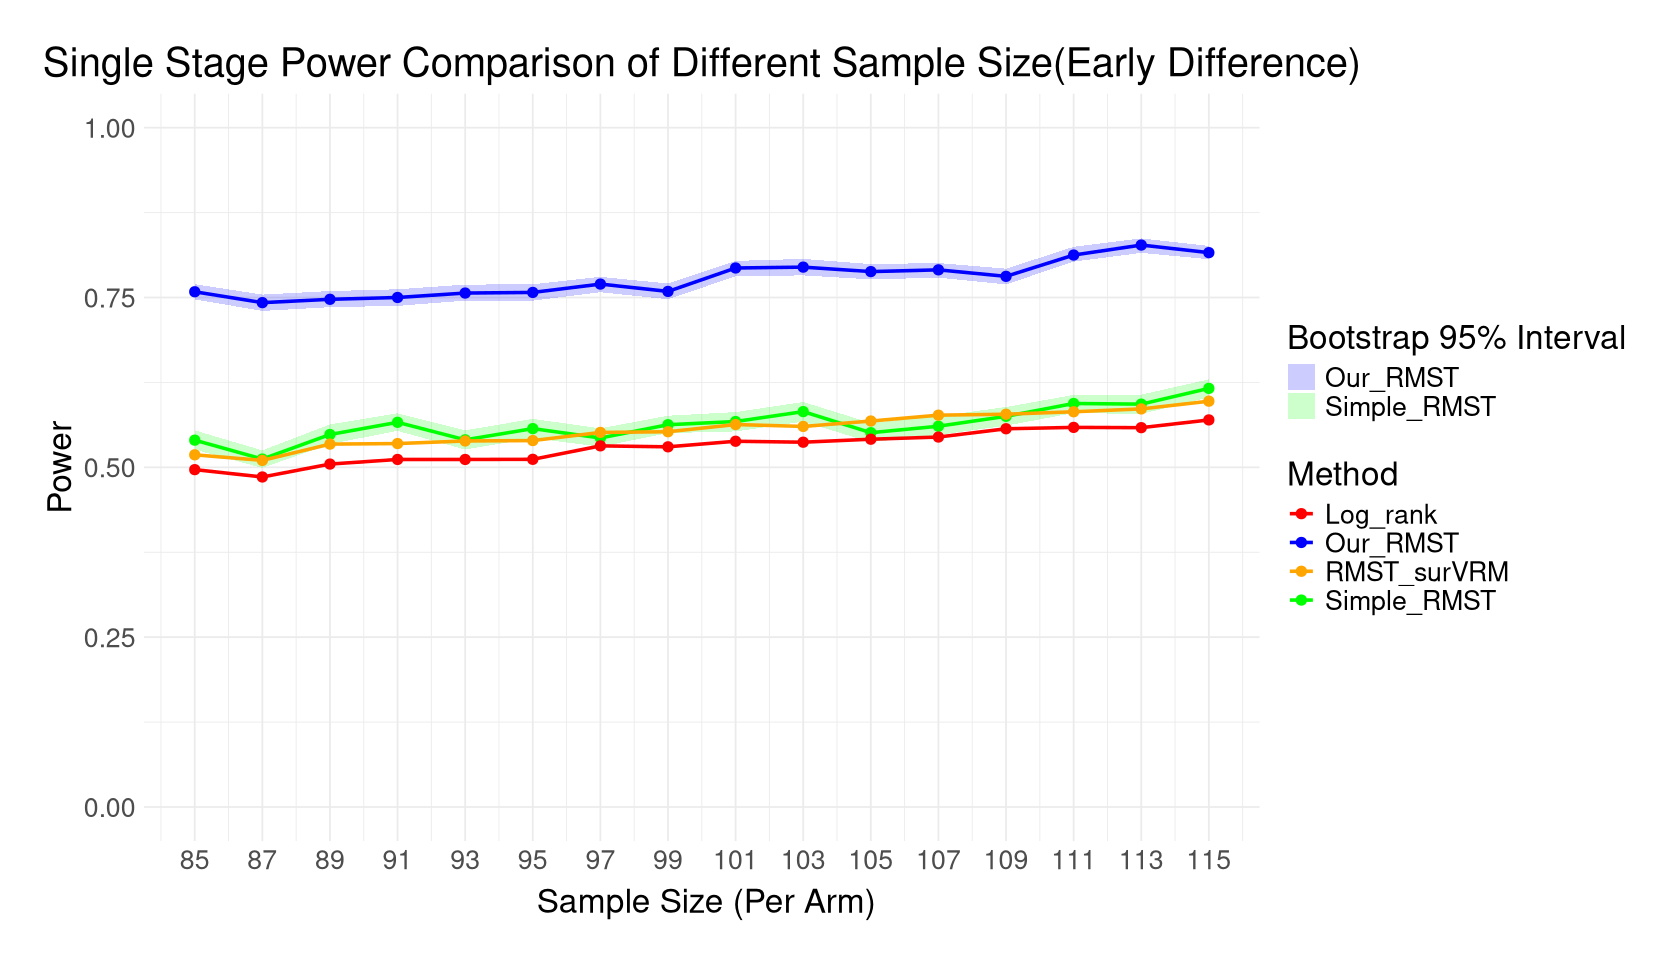

In [24]:
diff_n_single <- data.frame(diff_n_single)
colnames(diff_n_single) <- c('n','Log_Rank','RMST_surVRM','sim_rmst_0.025','Simple_RMST',
                         'sim_rmst_0.975', 'our_rmst_0.025', 'Our_RMST', 'our_rmst_0.975')

options(repr.plot.width = 14, repr.plot.height = 8)                      
ggplot() +
     geom_ribbon(data = diff_n_single, aes(x = n, ymin = sim_rmst_0.025, 
                    ymax = sim_rmst_0.975,  fill = "Simple_RMST"), alpha = 0.2) +
     geom_line(data = diff_n_single, aes(x = n, y = Simple_RMST, color = "Simple_RMST"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Simple_RMST, color = "Simple_RMST"), size = 2.5) +

     geom_ribbon(data = diff_n_single, aes(x = n, ymin = our_rmst_0.025, 
                    ymax = our_rmst_0.975, fill = "Our_RMST"), alpha = 0.2) +
     geom_line(data = diff_n_single, aes(x = n, y = Our_RMST, color = "Our_RMST"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Our_RMST, color = "Our_RMST"), size = 2.5) +

     geom_line(data = diff_n_single, aes(x = n, y = Log_Rank, color = "Log_rank"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Log_Rank, color = "Log_rank"), size = 2.5) +
     geom_line(data = diff_n_single, aes(x = n, y = RMST_surVRM, color = "RMST_surVRM"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = RMST_surVRM, color = "RMST_surVRM"), size = 2.5) +
     
     theme_minimal() +
     scale_x_continuous(breaks = diff_n_single$n) + 
     labs(
          color = "Method",
          fill = "Bootstrap 95% Interval",
          title = "Single Stage Power Comparison of Different Sample Size(Early Difference)",
          x = " Sample Size (Per Arm)",
          y = "Power"
          ) +
     scale_fill_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue")) +
     scale_color_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue", 
                                   "Log_rank" = "red", "RMST_surVRM" = "orange")) +
     scale_y_continuous(limits = c(0, 1)) +
     theme(text = element_text(size = 20),
          axis.title.x = element_text(vjust = 0),
          axis.title.y = element_text(vjust = 1),
          plot.title = element_text(hjust = 0.5),
          plot.margin = unit(c(1, 1, 1, 1), "cm"))

----
## Late Difference

In [11]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 5000  
r <- 90    # patient recruit rate
cen_time <- 1
change_time <- 200 * 0.5 / 90 # The time point between HR1 and HR2
set.seed(2024)
num_bootstrap <- 500 

diff_n_single <- foreach(n = seq(85, 115, by = 2), .combine = rbind) %dopar%
    {
        acc_time <- 2 * n / r
        interim <- acc_time

        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)  
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
                            
        log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, n = n, alpha = 0.05 ,sided = 'greater')
        simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = acc_time + cen_time, n = n
                            ,alpha = 0.05 ,sided = 'greater')

        # Monte Carlo for calculating critical value
        rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h0_int <- rmst_h0_fin                                 
        rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_int <- rmst_h1_fin 
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
        # Under H0
        mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
        # Under H1
        mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)
        best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
        best_RMST <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Simple')
        m_sim <- as.numeric(best_RMST$m1)
        m_our <- as.numeric(best_our$m1)
        t_our <- as.numeric(best_our$t1)
        boot_sim_rmst <- c()
        boot_our_rmst <- c()
        for (i in 1:num_bootstrap) 
        {   # Resample with replacement from H0 and H1
            bootstrap_H0 <- rmst_h0_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            bootstrap_H1 <- rmst_h1_fin[ , sample(1:sim_size, sim_size, replace = TRUE)]
            alpha_sim <- sum(bootstrap_H0[2, ] - bootstrap_H0[1, ] > m_sim) / sim_size
            power_sim <- sum(bootstrap_H1[2, ] - bootstrap_H1[1, ] > m_sim) / sim_size
            alpha_our <- sum(bootstrap_H0[2, ] - bootstrap_H0[1, ] > m_our &
                             bootstrap_H0[2, ] >  t_our) / sim_size
            power_our <- sum(bootstrap_H1[2, ] - bootstrap_H1[1, ] > m_our &
                             bootstrap_H1[2, ] >  t_our) / sim_size
            boot_sim_rmst <- cbind(boot_sim_rmst, c(alpha_sim, power_sim))
            boot_our_rmst <- cbind(boot_our_rmst, c(alpha_our, power_our))
        }
        sim_result <- c(quantile(boot_sim_rmst[2,], 0.025), mean(boot_sim_rmst[2,]), 
                        quantile(boot_sim_rmst[2,], 0.975))
        our_result <- c(quantile(boot_our_rmst[2,], 0.025), mean(boot_our_rmst[2,]), 
                        quantile(boot_our_rmst[2,], 0.975))

        c(n, log_rank_1$rejection, simple_rmst_1$test_result$rejection, 
            sim_result, our_result)      
    }

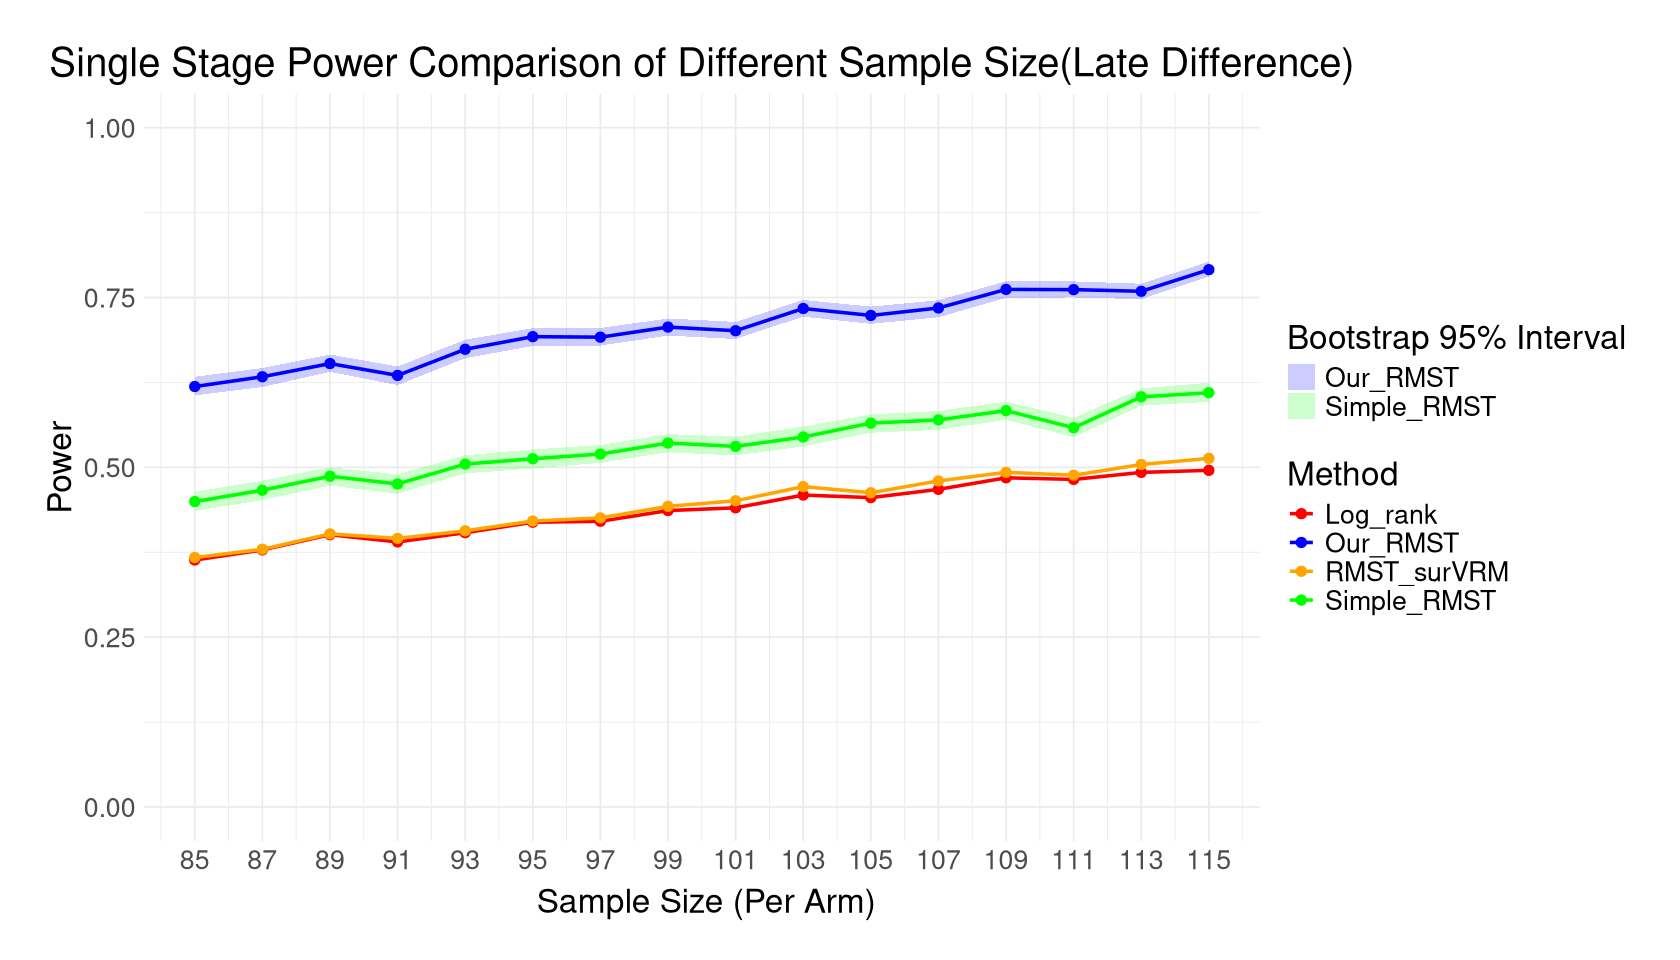

In [14]:
diff_n_single <- data.frame(diff_n_single)
colnames(diff_n_single) <- c('n','Log_Rank','RMST_surVRM','sim_rmst_0.025','Simple_RMST',
                         'sim_rmst_0.975', 'our_rmst_0.025', 'Our_RMST', 'our_rmst_0.975')

options(repr.plot.width = 14, repr.plot.height = 8)                      
ggplot() +
     geom_ribbon(data = diff_n_single, aes(x = n, ymin = sim_rmst_0.025, 
                    ymax = sim_rmst_0.975,  fill = "Simple_RMST"), alpha = 0.2) +
     geom_line(data = diff_n_single, aes(x = n, y = Simple_RMST, color = "Simple_RMST"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Simple_RMST, color = "Simple_RMST"), size = 2.5) +

     geom_ribbon(data = diff_n_single, aes(x = n, ymin = our_rmst_0.025, 
                    ymax = our_rmst_0.975, fill = "Our_RMST"), alpha = 0.2) +
     geom_line(data = diff_n_single, aes(x = n, y = Our_RMST, color = "Our_RMST"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Our_RMST, color = "Our_RMST"), size = 2.5) +
     geom_line(data = diff_n_single, aes(x = n, y = Log_Rank, color = "Log_rank"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = Log_Rank, color = "Log_rank"), size = 2.5) +
     geom_line(data = diff_n_single, aes(x = n, y = RMST_surVRM, color = "RMST_surVRM"), linewidth = 1) +
     geom_point(data = diff_n_single, aes(x = n, y = RMST_surVRM, color = "RMST_surVRM"), size = 2.5) +
     theme_minimal() +
     scale_x_continuous(breaks = diff_n_single$n) + 
     labs( color = "Method", fill = "Bootstrap 95% Interval",
          title = "Single Stage Power Comparison of Different Sample Size(Late Difference)",
          x = " Sample Size (Per Arm)", y = "Power") +
     scale_fill_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue")) +
     scale_color_manual(values = c("Simple_RMST" = "green", "Our_RMST" = "blue", 
                                   "Log_rank" = "red", "RMST_surVRM" = "orange")) +
     scale_y_continuous(limits = c(0, 1)) +
     theme(text = element_text(size = 20),
          axis.title.x = element_text(vjust = 0),
          axis.title.y = element_text(vjust = 1),
          plot.title = element_text(hjust = 0.5),
          plot.margin = unit(c(1, 1, 1, 1), "cm"))